# Setup

In [1]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from experiments.irl.fair_irl import *
from imblearn.under_sampling import RandomUnderSampler
from research.irl.fair_irl import *
from research.ml.svm import SVM
from research.utils import *
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold


logging.basicConfig(level=logging.INFO)

cp = sns.color_palette()

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_colwidth', None)

# Set Parameters

In [2]:
from fairlearn.reductions import DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer


class ReductionWrapper():
    def __init__(self, clf):
        self.clf = clf
    
    def fit(self, X, y, **kwargs):
        self.clf.fit(X, y, sensitive_features=X['z'])
        return self
    
    def predict(self, X, **kwargs):
        return self.clf.predict(X, sensitive_features=X['z'])



In [15]:
N_TRIALS = 5

##
# Objective set - the fairness metrics to consider.
##
obj_set = ObjectiveSet([
    AccuracyObjective(),
    DisparateImpactObjective(),
    EqualOpportunityObjective(),
])

##
# Expert demonstration parameters
##
N_EXPERT_DEMOS = 3
EXPERT_ALGO = 'pos_pred_to_female_only'
# These are the feature types that will be used in the classifier that will
# produce the expert feature demonstrations.
expert_demo_feature_types = {
    'boolean': [
        'z',
        'gender',
    ],
    'categoric': [
        'workclass',
        'education',
#         'marital-status',
        # 'occupation',
        # 'relationship',
        # 'native-country',
    ],
    'continuous': [
#         'age',
        # 'educational-num',
        # 'capital-gain',
        # 'capital-loss',
        # 'hours-per-week',
    ],
    'meta': [
        'fnlwgt'
    ],
}
pipe = sklearn_clf_pipeline(
    feature_types=expert_demo_feature_types,
    clf_inst=RandomForestClassifier(),
)
dem_par_thresh_opt = ThresholdOptimizer(
    estimator=pipe,
    constraints="demographic_parity",
    predict_method="predict",
    prefit=False,
)
dem_par_reduction = ReductionWrapper(dem_par_thresh_opt)
eq_opp_thresh_opt = ThresholdOptimizer(
    estimator=pipe,
    constraints='true_positive_rate_parity',
    predict_method="predict",
    prefit=False,
)
eq_opp_reduction = ReductionWrapper(eq_opp_thresh_opt)

EXPERT_ALGO_LOOKUP = {
    'optimize_accuracy': sklearn_clf_pipeline(expert_demo_feature_types, RandomForestClassifier()),
    'pos_pred_to_female_only': ManualClassifier(lambda row: int(row['gender'] == 'Female')),
    'disp_imp_threshold_op': dem_par_reduction,
    'eq_opp_threshold_op': eq_opp_thresh_opt,
}

##
# IRL loop parameters
##
IRL_METHOD = 'ClfIRL'
N_INIT_POLICIES = 1
NO_NEG_WEIGHTS = False
SAMPLE_LEARNED_POLICIES = False
RANDOM_WEIGHT_RATE = 0
SKIP_ERROR_TERMS = True
METHOD = 'highs'
epsilon = .01
max_iter = 5

if IRL_METHOD == 'ClfIRL':
    CAN_OBSERVE_Y = False
elif IRL_METHOD == 'ClfIRLFO':
    CAN_OBSERVE_Y = True
##
# Plotting parameters
##
ANNOTATE = True
NOISE_FACTOR = .02

# Execute

INFO:root:
TRIAL 0

INFO:root:Dataset count of each z, y group
INFO:root:
	       y         
	   count     mean
	z                
	0   3557  0.15097
	1  21443  0.25752



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,is_income_over_50k,is_race_white,z,y
4435,64,Self-emp-not-inc,46366,Some-college,10,Widowed,Exec-managerial,Not-in-family,White,Female,0,0,60,United-States,<=50K,False,True,1,0
10321,48,Self-emp-not-inc,162236,Masters,14,Widowed,Exec-managerial,Unmarried,White,Female,0,0,40,?,>50K,True,True,1,1
8473,42,Private,107762,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K,True,True,1,1
6574,28,Private,192384,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K,True,True,1,1
354,40,Self-emp-not-inc,355856,Bachelors,13,Married-spouse-absent,Exec-managerial,Not-in-family,Asian-Pac-Islander,Male,0,0,40,United-States,<=50K,False,False,0,0


,,count,mean_y
z,gender,,
1,Male,7906,0.596509
0,Male,922,0.458785
1,Female,2707,0.297747
0,Female,583,0.195540


INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.27853712596970814
INFO:root:Expert demo yhat:	 0.2583148558758315
INFO:root:Expert demo yhat:	 0.26570583887657057
INFO:root:Best Learned Policy yhat: 0.250
INFO:root:best weight:	 [-0.418  0.265  0.317]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.393424,0.817510,0.982968,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.386918,0.829638,0.958731,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.376940,0.829638,0.923796,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.479104,0.648134,0.989279,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.418355,0.913478,0.205693,0,0.0,1.0,0.0,-0.327815,0.648039,-0.024146,0.548836,0.755311
5,0.433108,0.985246,0.646921,0,0.0,2.0,0.0,-0.321845,0.487970,0.190185,0.215363,0.350349
6,0.433108,0.984246,0.645830,0,0.0,3.0,0.0,-0.417927,0.264993,0.317080,0.206208,0.350856
7,0.423856,0.899975,0.762033,0,0.0,4.0,0.0,-0.417926,0.264986,0.317087,0.123679,0.210436
8,0.309827,0.584896,0.981346,0,0.0,5.0,0.0,-0.410489,0.232310,0.357201,0.150132,0.253747


INFO:root:
TRIAL 1

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3627  0.151916
	1  21373  0.255088



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,is_income_over_50k,is_race_white,z,y
9817,31,Private,323055,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,>50K,True,True,1,1
10711,52,Private,99307,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,3103,0,48,United-States,>50K,True,True,1,1
3848,61,Private,132529,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K,False,True,1,0
8433,47,Private,166181,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,Black,Female,0,0,48,United-States,>50K,True,False,0,1
7378,60,Private,176360,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K,True,True,1,1


,,count,mean_y
z,gender,,
1,Male,7900,0.591772
0,Male,931,0.471536
1,Female,2618,0.296791
0,Female,557,0.201077


INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.2606263982102908
INFO:root:Expert demo yhat:	 0.278254382693025
INFO:root:Expert demo yhat:	 0.2525177172696755
INFO:root:Best Learned Policy yhat: 0.551
INFO:root:best weight:	 [-0.54   0.087  0.374]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.387025,0.825130,0.941166,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.371503,0.829914,0.879892,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.402089,0.821335,0.970822,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.506591,0.642561,0.917628,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.424281,0.975265,0.721486,0,0.0,1.0,0.0,-0.312181,0.532557,0.155262,0.165476,0.259963
5,0.303130,0.606764,0.993104,0,0.0,2.0,0.0,-0.539716,0.086707,0.373577,0.160473,0.242372
6,0.445230,0.983594,0.144555,0,0.0,3.0,0.0,0.047327,0.395266,0.557407,0.550671,0.803941
7,0.443210,0.979556,0.137903,0,0.0,4.0,0.0,0.047337,0.395292,0.557370,0.554485,0.809525
8,0.445230,0.983594,0.144555,0,0.0,5.0,0.0,0.047360,0.395349,0.557292,0.550636,0.803941


INFO:root:
TRIAL 2

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3648  0.155702
	1  21352  0.257821



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,is_income_over_50k,is_race_white,z,y
8840,60,Self-emp-not-inc,127805,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,>50K,True,True,1,1
468,29,Private,190911,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K,False,True,1,0
12032,42,Local-gov,445382,Bachelors,13,Separated,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States,>50K,True,True,1,1
6339,43,Federal-gov,111483,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,40,United-States,>50K,True,True,1,1
3087,51,Local-gov,96678,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,<=50K,False,True,1,0


,,count,mean_y
z,gender,,
1,Male,7909,0.595271
0,Male,950,0.481053
1,Female,2678,0.297610
0,Female,609,0.182266


INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.28271286398820494
INFO:root:Expert demo yhat:	 0.2713864306784661
INFO:root:Expert demo yhat:	 0.2581120943952802
INFO:root:Best Learned Policy yhat: 0.478
INFO:root:best weight:	 [-0.564  0.089  0.347]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.366384,0.827866,0.927005,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.383850,0.827434,0.909271,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.388274,0.839971,0.946003,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.507818,0.620625,0.959444,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.445248,0.962834,0.106847,0,0.0,1.0,0.0,-0.325419,0.542874,-0.131707,0.538905,0.833579
5,0.443502,0.981043,0.762641,0,0.0,2.0,0.0,-0.333702,0.457976,0.208322,0.139692,0.231379
6,0.308556,0.669993,0.997694,0,0.0,3.0,0.0,-0.564365,0.088722,0.346913,0.127060,0.190102
7,0.521327,0.988526,0.368228,0,0.0,4.0,0.0,0.175727,0.311309,0.512963,0.373783,0.597824
8,0.518583,0.987778,0.369904,0,0.0,5.0,0.0,0.175580,0.311316,0.513104,0.372322,0.595413


INFO:root:
TRIAL 3

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3658  0.151176
	1  21342  0.254850



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,is_income_over_50k,is_race_white,z,y
11811,44,Private,125461,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,35,United-States,>50K,True,True,1,1
9728,41,Local-gov,183224,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Asian-Pac-Islander,Female,0,0,40,Taiwan,>50K,True,False,0,1
7985,33,Private,254221,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,60,United-States,>50K,True,True,1,1
3089,33,Private,30612,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K,False,True,1,0
5251,21,Private,203003,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K,False,True,1,0


,,count,mean_y
z,gender,,
1,Male,7846,0.595972
0,Male,948,0.455696
1,Female,2593,0.294254
0,Female,597,0.202680


INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.2633545013074337
INFO:root:Expert demo yhat:	 0.2615844544095665
INFO:root:Expert demo yhat:	 0.27167414050822125
INFO:root:Best Learned Policy yhat: 0.501
INFO:root:best weight:	 [-0.473  0.194  0.333]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.375420,0.841240,0.887811,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.385277,0.822123,0.967093,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.370703,0.828475,0.923729,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.494340,0.609811,0.969666,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.446018,0.950442,0.206157,0,0.0,1.0,0.0,-0.336670,0.655390,-0.007940,0.540257,0.733200
5,0.449305,0.958786,0.701726,0,0.0,2.0,0.0,-0.313464,0.461019,0.225518,0.161402,0.268386
6,0.319090,0.654109,0.988766,0,0.0,3.0,0.0,-0.472923,0.194390,0.332687,0.119595,0.196050
7,0.473325,0.944374,0.117447,0,0.0,4.0,0.0,-0.081720,0.463430,0.454850,0.538219,0.822371
8,0.473325,0.944374,0.117447,0,0.0,5.0,0.0,-0.081771,0.463281,0.454948,0.538194,0.822371


INFO:root:
TRIAL 4

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3605  0.151179
	1  21395  0.252863



,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,is_income_over_50k,is_race_white,z,y
2215,18,Private,152044,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,3,United-States,<=50K,False,True,1,0
2829,47,Private,112791,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K,False,True,1,0
11835,36,Private,188563,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,5178,0,50,United-States,>50K,True,True,1,1
9681,39,Private,167728,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K,True,True,1,1
2144,27,Private,220931,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,32,United-States,<=50K,False,True,1,0


,,count,mean_y
z,gender,,
1,Male,7800,0.595128
0,Male,933,0.460879
1,Female,2580,0.297674
0,Female,597,0.192630


INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.25977443609022555
INFO:root:Expert demo yhat:	 0.2650375939849624
INFO:root:Expert demo yhat:	 0.2719067318540805
INFO:root:Best Learned Policy yhat: 0.515
INFO:root:best weight:	 [-0.408  0.221  0.372]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.381203,0.838722,0.935085,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.386466,0.839474,0.955500,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.384731,0.818353,0.965825,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.501139,0.635535,0.994088,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.409056,0.988553,0.100288,0,0.0,1.0,0.0,-0.355457,0.558241,-0.086302,0.578268,0.866441
5,0.415925,0.999491,0.684636,0,0.0,2.0,0.0,-0.333410,0.453237,0.213352,0.190822,0.317111
6,0.310099,0.636734,0.963641,0,0.0,3.0,0.0,-0.407532,0.220689,0.371779,0.124364,0.209317
7,0.451793,0.997711,0.157495,0,0.0,4.0,0.0,-0.078345,0.413598,0.508057,0.537409,0.814514
8,0.434749,0.989316,0.153008,0,0.0,5.0,0.0,-0.078340,0.413605,0.508054,0.538392,0.816002


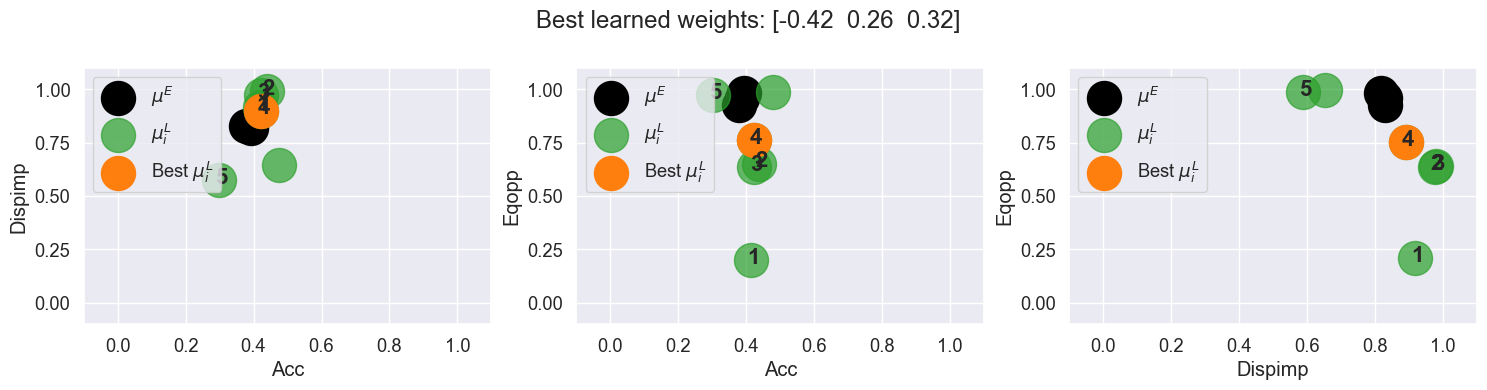

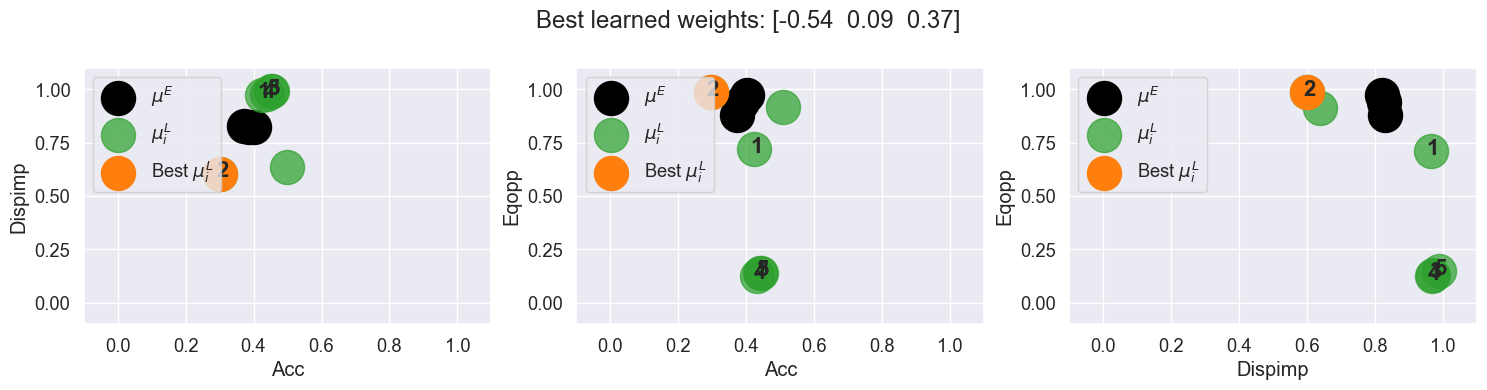

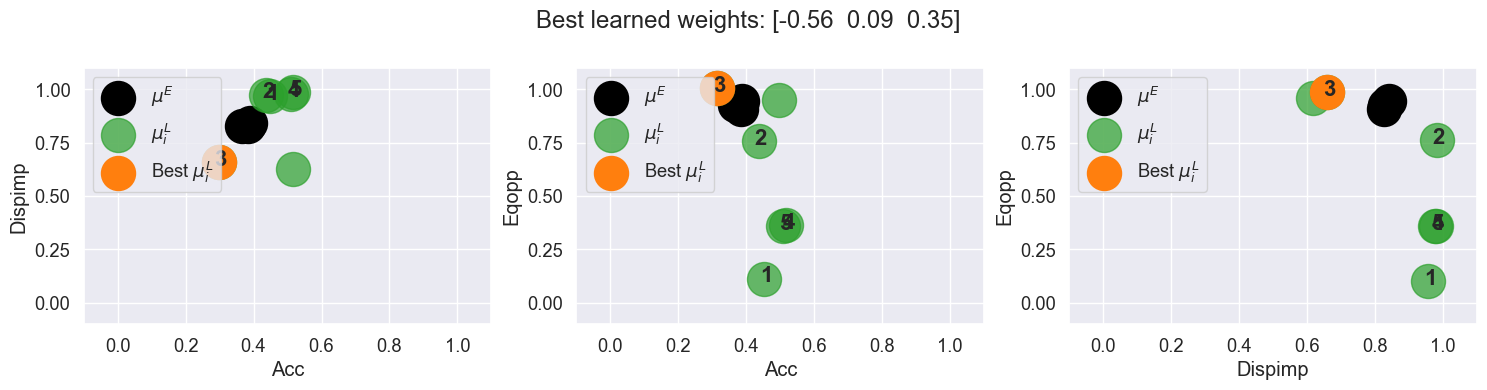

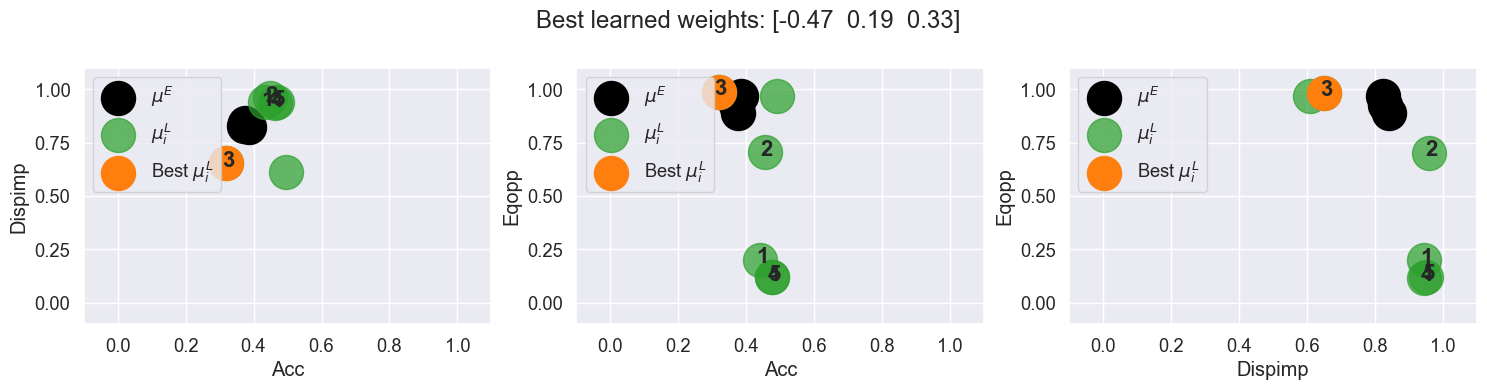

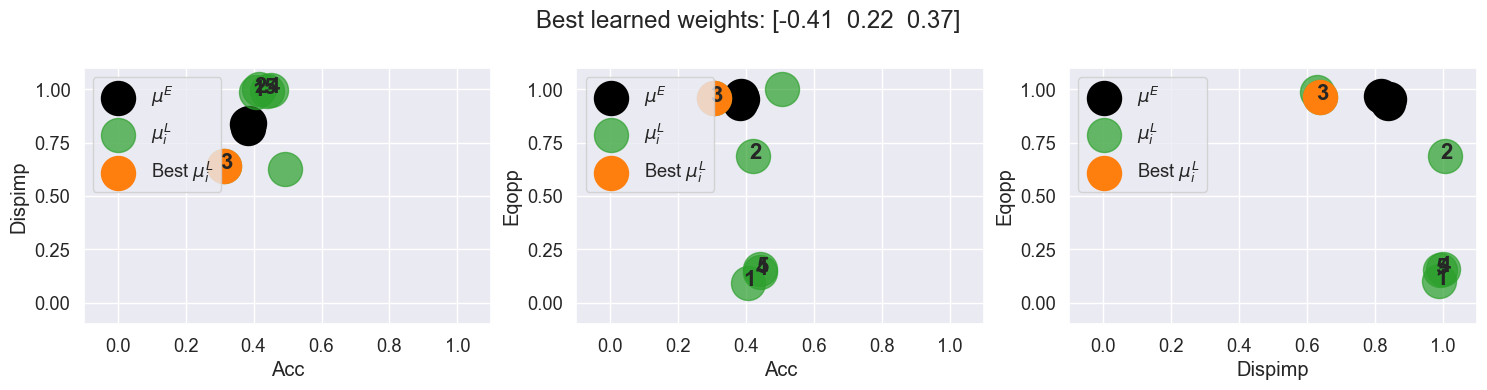

In [16]:
##
# Set aggregation variables
##
results = []
trial_i = 0

##
# Run the experiment trials
##
while trial_i < N_TRIALS:
    logging.info(f"\nTRIAL {trial_i}\n")
    ##
    # Reset the objective set since they get fitted in each trial run
    ##
    obj_set.reset()

    ##
    # Read in Adult dataset
    ##

    df, X, y = generate_adult_dataset(
        filepath='./../../data/adult/adult.csv',
        n=25_000,
    )
    rus = RandomUnderSampler(sampling_strategy=1)
    X, y = rus.fit_resample(X, y)
    df = X
    df['y'] = y

    display(df.sample(5))
    temp = (
        df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
        ['y'].sort_values(['mean', 'count'], ascending=False)
        .rename(columns={'mean': 'mean_y'})
    )
    display(temp)

    ##
    # Split data into two: (X_demo, y_demo), (X_irl_valid, y_irl_valid). The
    # former is used for generating the expert's demonstrations. The latter is
    # used in the IRL loop for learning the optimal policies for a given reward
    # function.
    ##
    X_demo, X_irl_valid, y_demo, y_irl_valid = train_test_split(
        X, y, test_size=.33)

    del X, y  # Make sure I don't acidentally use these variables later on


    ##
    # Generate expert demonstrations
    ##
    muE, demosE = generate_demos_k_folds(
        X_demo=X_demo,
        y_demo=y_demo,
        clf=EXPERT_ALGO_LOOKUP[EXPERT_ALGO],
        obj_set=obj_set,
        n_demos=N_EXPERT_DEMOS,
    )
    logging.debug(muE)

    ##
    # Run IRL loop.
    # Create a clf dataset where inputs are feature expectations and outputs are
    # whether the policy is expert or learned through IRL iterations. Then train
    # an SVM classifier on this dataset. Then extract the weights of the svm and
    # use them as the weights for the "reward" function. Then use this reward
    # function to learn a policy (classifier). Then compute the feature
    # expectations from this classifer on the irl hold-out set. Then compute the
    # error between the feature expectations of this learned clf and the
    # demonstration feature exp. If this error is less than epsilon, stop. The
    # reward function is the final set of weights.
    ##


    # These are the feature types that will be used in the classifier that will
    # predict `y` given `X` when learning the optimal policy for a given reward
    # function.
    irl_loop_feature_types = {
        'boolean': [
            'z',
            'gender',
        ],
        'categoric': [
            'workclass',
            'education',
    #         'marital-status',
    #         'occupation',
            # 'relationship',
            # 'native-country',
        ],
        'continuous': [
    #         'age',
            # 'educational-num',
            # 'capital-gain',
            # 'capital-loss',
            # 'hours-per-week',
        ],
        'meta': [
            'fnlwgt'
        ],
    }
    x_cols = (
        irl_loop_feature_types['boolean']
        + irl_loop_feature_types['categoric']
        + irl_loop_feature_types['continuous']
    )
    x_cols.remove('z')
    obj_set_cols = [obj.name for obj in obj_set.objectives]


    # Generate initial learned policies
    mu, _demos = generate_demos_k_folds(
        X_demo=X_demo,
        y_demo=y_demo,
        clf=DummyClassifier(strategy="uniform"),
        obj_set=obj_set,
        n_demos=N_INIT_POLICIES,
    )

    X_irl_exp = pd.DataFrame(muE, columns=obj_set_cols)
    y_irl_exp = pd.Series(np.ones(N_EXPERT_DEMOS), dtype=int)
    X_irl_learn = pd.DataFrame(mu, columns=obj_set_cols)
    y_irl_learn = pd.Series(np.zeros(len(mu)), dtype=int)

    t = []  # Errors for each iteration
    mu_delta_l2norm_hist = []
    weights = []
    i = 0
    demo_history = []
    mu_history = []
    is_random_weight = []

    logging.debug('')
    logging.debug('Starting IRL Loop ...')

    while True:
        logging.info(f"\tIRL Loop iteration {i+1}/{max_iter} ...")

        # Train SVM classifier that distinguishes which demonstrations are expert
        # and which were generated from this loop.
        logging.debug('\tFitting SVM classifier...')
        if SAMPLE_LEARNED_POLICIES and i > 2:
            # TRY SAMPLING FROM LEARNE DPOLICIES TO AVOID LOCAL OPTIMUM ISSUE
            # n_samples_to_use = np.random.randint(low=2, high=len(X_irl_learn)-1)
            n_samples_to_use = 2
            sampled_idx = X_irl_learn.sample(n_samples_to_use).index
            sampled_X_irl_learn = X_irl_learn.loc[sampled_idx].copy()
            sampled_y_irl_learn = y_irl_learn.loc[sampled_idx].copy()
            X_irl = pd.concat([X_irl_exp, sampled_X_irl_learn], axis=0).reset_index(drop=True)
            y_irl = pd.concat([y_irl_exp, sampled_y_irl_learn], axis=0).reset_index(drop=True)
            svm = SVM().fit(X_irl, y_irl)
        else:
            X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
            y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
            svm = SVM().fit(X_irl, y_irl)

        if np.random.rand() < RANDOM_WEIGHT_RATE:
            wi = np.random.rand(len(obj_set.objectives))
            is_random_weight.append(1)
        else:
            # Extract the weights from the SVM classifier. These weights become the
            # reward weights.
            wi = svm.weights()
            is_random_weight.append(0)

        # Trying something out
        if NO_NEG_WEIGHTS:
            for _i, w in enumerate(wi):
                if w < 0:
                    wi[_i] = 0

        weights.append(wi)

        # Learn a policy (clf_pol) from the reward (SVM) weights.
        valid_df = pd.DataFrame(X_demo)
        valid_df['y'] = y_demo

        # Fit a classifier that predicts `y` from `X`.
        logging.debug('\tFitting `y|x` predictor for clf policy...')
        clf = sklearn_clf_pipeline(
            feature_types=irl_loop_feature_types,
            clf_inst=RandomForestClassifier(),
        )
        clf.fit(
            X=valid_df.iloc[:, :-1],
            y=valid_df.iloc[:, -1],
        )
        # Learn a policy that maximizes the reward function.
        logging.debug('\tComputing the optimal policy given reward weights and `y|x` classifier...')
        reward_weights = { obj.name: wi[j] for j, obj in enumerate(obj_set.objectives) }
        clf_pol = compute_optimal_policy(
            clf_df=valid_df,
            clf=clf,
            x_cols=x_cols,
            obj_set=obj_set,
            reward_weights=reward_weights,
            skip_error_terms=SKIP_ERROR_TERMS,
            method=METHOD,
        )

        # Compute feature expectations of the learned policy
        logging.debug('\tGenerating learned demostration...')
        demo = generate_demo(clf_pol, X_irl_valid, y_irl_valid, can_observe_y=CAN_OBSERVE_Y)
        demo_history.append(demo)
        muj = obj_set.compute_demo_feature_exp(demo)
        mu_history.append(muj)
        logging.debug(f"\t\t muL[i] = {np.round(muj, 3)}")

        # Append policy's feature expectations to irl clf dataset
        X_irl_learn_i = pd.DataFrame(np.array([muj]), columns=obj_set_cols)
        y_irl_learn_i = pd.Series(np.zeros(1), dtype=int)
        X_irl_learn = pd.concat([X_irl_learn, X_irl_learn_i], axis=0)
        y_irl_learn = pd.concat([y_irl_learn, y_irl_learn_i], axis=0)

        # Compute error of the learned policy: t[i] = wT(muE-mu[j])
        ti, mu_delta, mu_delta_l2norm= irl_error(wi, muE, muj)
        t.append(ti)
        mu_delta_l2norm_hist.append(mu_delta_l2norm)
        logging.debug(f"\t\t mu_delta[i] \t= {np.round(mu_delta, 3)}")
        logging.debug(f"\t\t t[i] \t\t= {t[i]:.5f}")
        logging.debug(f"\t\t weights[{i}] \t= {np.round(weights[i], 3)}")

        # Show a summary of the learned policy
    #     logging.info(
    #         df_to_log(
    #             demo.groupby(['z']+x_cols+['y', 'yhat'])[['age']].agg(['count']),
    #             title='\tLearned Policy:',
    #             tab_level=3,
    #         )
    #     )

        if ti < epsilon or i >= max_iter - 1:
            break

        i += 1


    print('\n'+ 100*'-' + '\n')

    # Compare the best learned policy with the expert demonstrations
    for demo in demosE:
        logging.info(f"Expert demo yhat:\t {demo['yhat'].mean()}")
    #     display(demo.groupby(['z']+x_cols+['y'])[['yhat']].agg(['count', 'mean']))

    logging.debug('\n'+ 100*'-' + '\n')

    best_iter = np.argmin(t)
    logging.debug('Best iteration: ' + str(best_iter))
    best_demo = demo_history[best_iter]
    logging.info(f"Best Learned Policy yhat: {best_demo['yhat'].mean():.3f}")
    # display(
    #     best_demo.groupby(['z']+x_cols+['y'])[['yhat']].agg(['count', 'mean'])
    # )
    best_weight = weights[best_iter]
    logging.info(f"best weight:\t {np.round(best_weight, 3)}")

    logging.debug('\n'+ 100*'-' + '\n')
    X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
    y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
    df_irl = X_irl.copy()
    df_irl['is_expert'] = y_irl.copy()
    df_irl['is_init_policy'] = np.zeros(N_EXPERT_DEMOS).tolist() + np.ones(N_INIT_POLICIES).tolist() + np.zeros(len(t)).tolist()
    df_irl['learn_idx'] = list(-1*np.ones(N_EXPERT_DEMOS)) + list(np.arange(N_INIT_POLICIES + len(t)))
    df_irl['is_random_weight'] = np.zeros(N_EXPERT_DEMOS+N_INIT_POLICIES).tolist() + is_random_weight
    for i, col in enumerate(obj_set_cols):
        df_irl[f"{col}_weight"] = np.zeros(N_EXPERT_DEMOS+N_INIT_POLICIES).tolist() + [w[i] for w in weights]
    df_irl['t'] = list(np.inf*(np.ones(N_EXPERT_DEMOS+N_INIT_POLICIES))) + t
    df_irl['mu_delta_l2norm'] = np.zeros(N_EXPERT_DEMOS+N_INIT_POLICIES).tolist() + mu_delta_l2norm_hist
    logging.debug('Historical feature expectations')
    display(df_irl)

    ##
    # Plot results
    ##
    sns.set_theme(style='darkgrid', font_scale=1.2)

    feat_exp_combs = list(itertools.combinations(obj_set_cols, 2))

    exp = df_irl.query('is_expert == True').reset_index(drop=True)
    lrn = df_irl.query('is_expert == False and is_random_weight == 0').reset_index(drop=True)
    best_t_idx = lrn.query('t > 0')['t'].argmin()

    fig, axes = plt.subplots(1, len(feat_exp_combs), figsize=(5*len(feat_exp_combs), 4))
    axes = (axes,) if len(feat_exp_combs) == 1 else axes
    for i, (feat_exp_x, feat_exp_y) in enumerate(feat_exp_combs):
        # Plot expert
        axes[i].scatter(exp[feat_exp_x], exp[feat_exp_y], label='$\mu^E$', s=600, alpha=1, c='black')
        # Inject noise so we can see the expert when it's overlapping
        noise = NOISE_FACTOR*(np.random.rand(len(lrn))-.6)
        # Plot the learned policies
        axes[i].scatter(lrn[feat_exp_x]+noise, lrn[feat_exp_y]+noise, label='$\mu^L_i$', s=600, alpha=.7, c=cp[2])
        axes[i].set_ylim([-.1, 1.1])
        axes[i].set_xlim([-.1, 1.1])
        axes[i].set_xlabel(feat_exp_x.replace('_', ' ').title())
        axes[i].set_ylabel(feat_exp_y.replace('_', ' ').title())
        if ANNOTATE:
            # Label each learned policy with its ordered index
            for idx, row in lrn.iterrows():
                if row['is_init_policy']:
                    annotation = None
                else:
                    annotation = idx
                axes[i].annotate(annotation, (-.012+(row[feat_exp_x]+noise[idx]), -.015+(row[feat_exp_y]+noise[idx])), fontsize=16, fontweight=700)
        # Color the best policy
        axes[i].scatter([lrn.loc[best_t_idx][feat_exp_x]+noise[best_t_idx]], [lrn.loc[best_t_idx][feat_exp_y]+noise[best_t_idx]], label='Best $\mu^L_i$', s=600, alpha=1, c=cp[1])
        axes[i].legend(ncol=1, labelspacing=.7, loc='upper left')

    plt.suptitle(f"Best learned weights: {best_weight.round(2)}")
    plt.tight_layout()

    ##
    # Append results
    ##
    results.append(new_trial_result(obj_set, muE, df_irl))
    
    trial_i += 1

In [17]:
exp_df = generate_single_exp_results_df(obj_set, results)
exp_df

,muE_Acc_mean,muE_Acc_std,muE_DispImp_mean,muE_DispImp_std,muE_EqOpp_mean,muE_EqOpp_std,wL_Acc,wL_DispImp,wL_EqOpp,muL_Acc,muL_DispImp,muL_EqOpp,muL_err_Acc,muL_err_DispImp,muL_err_EqOpp,muL_err_l2norm
0,0.385761,0.006779,0.825595,0.005717,0.955165,0.024288,-0.417926,0.264986,0.317087,0.423856,0.899975,0.762033,0.038095,0.074380,0.193132,0.210436
1,0.386872,0.012487,0.825460,0.003510,0.930627,0.037863,-0.539716,0.086707,0.373577,0.303130,0.606764,0.993104,0.083742,0.218696,0.062478,0.242372
2,0.379503,0.009450,0.831757,0.005811,0.927426,0.014999,-0.564365,0.088722,0.346913,0.308556,0.669993,0.997694,0.070947,0.161764,0.070267,0.190102
3,0.377133,0.006072,0.830613,0.007950,0.926211,0.032414,-0.472923,0.194390,0.332687,0.319090,0.654109,0.988766,0.058043,0.176504,0.062554,0.196050
4,0.384133,0.002190,0.832183,0.009784,0.952137,0.012773,-0.407532,0.220689,0.371779,0.310099,0.636734,0.963641,0.074034,0.195449,0.011504,0.209317


In [18]:
results_summary = {
    'n_trials': N_TRIALS,
    'data_demo':'Adult',
    'exp_algo': EXPERT_ALGO,
    'irl_method': IRL_METHOD,
}

for obj in obj_set.objectives:
    results_summary[f"wL_{obj.name}_mean"] = np.round(np.mean(exp_df[f"wL_{obj.name}"]), 3)
    results_summary[f"wL_{obj.name}_std"] = np.round(np.std(exp_df[f"wL_{obj.name}"]), 3)
    
for obj in obj_set.objectives:
    results_summary[f"muE_{obj.name}_mean"] = np.round(np.mean(exp_df[f"muE_{obj.name}_mean"]), 3)
    results_summary[f"muE_{obj.name}_std"] = np.round(np.mean(exp_df[f"muE_{obj.name}_std"]), 3)

for obj in obj_set.objectives:
    results_summary[f"muL_{obj.name}_mean"] = np.round(np.mean(exp_df[f"muL_{obj.name}"]), 3)
    results_summary[f"muL_{obj.name}_std"] = np.round(np.std(exp_df[f"muL_{obj.name}"]), 3)
    
for obj in obj_set.objectives:
    results_summary[f"muL_err_{obj.name}_mean"] = np.round(np.mean(exp_df[f"muL_err_{obj.name}"]), 3)
    results_summary[f"muL_err_{obj.name}_std"] = np.round(np.std(exp_df[f"muL_err_{obj.name}"]), 3)

results_summary['muL_err_l2norm_mean'] = np.round(np.mean(exp_df['muL_err_l2norm']), 3)
results_summary['muL_err_l2norm_std'] = np.round(np.std(exp_df['muL_err_l2norm']), 3)


results_summary

{'n_trials': 5,
 'data_demo': 'Adult',
 'exp_algo': 'pos_pred_to_female_only',
 'irl_method': 'ClfIRL',
 'wL_Acc_mean': -0.48,
 'wL_Acc_std': 0.063,
 'wL_DispImp_mean': 0.171,
 'wL_DispImp_std': 0.072,
 'wL_EqOpp_mean': 0.348,
 'wL_EqOpp_std': 0.022,
 'muE_Acc_mean': 0.383,
 'muE_Acc_std': 0.007,
 'muE_DispImp_mean': 0.829,
 'muE_DispImp_std': 0.007,
 'muE_EqOpp_mean': 0.938,
 'muE_EqOpp_std': 0.024,
 'muL_Acc_mean': 0.333,
 'muL_Acc_std': 0.046,
 'muL_DispImp_mean': 0.694,
 'muL_DispImp_std': 0.105,
 'muL_EqOpp_mean': 0.941,
 'muL_EqOpp_std': 0.09,
 'muL_err_Acc_mean': 0.065,
 'muL_err_Acc_std': 0.016,
 'muL_err_DispImp_mean': 0.165,
 'muL_err_DispImp_std': 0.049,
 'muL_err_EqOpp_mean': 0.08,
 'muL_err_EqOpp_std': 0.06,
 'muL_err_l2norm_mean': 0.21,
 'muL_err_l2norm_std': 0.018}

---
---
```
{'n_trials': 10,
 'data_demo': 'Adult',
 'exp_algo': 'optimize_accuracy',
 'irl_method': 'ClfIRLFO',
 'wL_Acc_mean': 0.181,
 'wL_Acc_std': 0.341,
 'wL_DispImp_mean': -0.308,
 'wL_DispImp_std': 0.359,
 'wL_EqOpp_mean': -0.09,
 'wL_EqOpp_std': 0.381,
 'muE_Acc_mean': 0.689,
 'muE_Acc_std': 0.005,
 'muE_DispImp_mean': 0.626,
 'muE_DispImp_std': 0.025,
 'muE_EqOpp_mean': 0.959,
 'muE_EqOpp_std': 0.023,
 'muL_Acc_mean': 1.0,
 'muL_Acc_std': 0.0,
 'muL_DispImp_mean': 0.597,
 'muL_DispImp_std': 0.008,
 'muL_EqOpp_mean': 1.0,
 'muL_EqOpp_std': 0.0,
 'muL_err_Acc_mean': 0.311,
 'muL_err_Acc_std': 0.005,
 'muL_err_DispImp_mean': 0.03,
 'muL_err_DispImp_std': 0.046,
 'muL_err_EqOpp_mean': 0.041,
 'muL_err_EqOpp_std': 0.015,
 'muL_err_l2norm_mean': 0.319,
 'muL_err_l2norm_std': 0.012}
 
 
{'n_trials': 50,
 'data_demo': 'Adult',
 'exp_algo': 'optimize_accuracy',
 'irl_method': 'ClfIRL',
 'wL_Acc_mean': 0.772,
 'wL_Acc_std': 0.158,
 'wL_DispImp_mean': -0.017,
 'wL_DispImp_std': 0.132,
 'wL_EqOpp_mean': 0.08,
 'wL_EqOpp_std': 0.152,
 'muE_Acc_mean': 0.686,
 'muE_Acc_std': 0.007,
 'muE_DispImp_mean': 0.62,
 'muE_DispImp_std': 0.025,
 'muE_EqOpp_mean': 0.955,
 'muE_EqOpp_std': 0.026,
 'muL_Acc_mean': 0.854,
 'muL_Acc_std': 0.192,
 'muL_DispImp_mean': 0.727,
 'muL_DispImp_std': 0.188,
 'muL_EqOpp_mean': 0.67,
 'muL_EqOpp_std': 0.351,
 'muL_err_Acc_mean': 0.234,
 'muL_err_Acc_std': 0.099,
 'muL_err_DispImp_mean': 0.147,
 'muL_err_DispImp_std': 0.163,
 'muL_err_EqOpp_mean': 0.289,
 'muL_err_EqOpp_std': 0.349,
 'muL_err_l2norm_mean': 0.498,
 'muL_err_l2norm_std': 0.263}
 ```

# Use learned rewards on Adult to predict on Compas dataset

In [310]:
# _df = pd.read_csv('./../../data/compas-scores-raw.csv')
# _df = pd.read_csv('./../../data/compas/propublica_data_for_fairml.csv')
# _df = pd.read_csv('./../../data/compas/cox-violent-parsed_filt.csv')
# _df = pd.read_csv('./../../data/compas/cox-violent-parsed.csv')
compas = pd.read_csv('./../../data/compas/cox-violent-parsed.csv')

In [311]:
df, X, y = generate_compas_dataset(
    filepath='./../../data/compas/cox-violent-parsed.csv',
    n=10_000,
)

display(
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)
rus = RandomUnderSampler(sampling_strategy=1)
X, y = rus.fit_resample(X, y)
df = X
df['y'] = y

display(
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)

INFO:root:Dataset count of each z, y group
INFO:root:
	      y          
	  count      mean
	z                
	0  6400  0.503906
	1  3164  0.421302



count    mean_y
z gender                 
0 Male     5424  0.530420
1 Male     2409  0.432130
  Female    755  0.386755
0 Female    976  0.356557

count    mean_y
z gender                 
0 Male     5205  0.552738
1 Male     2280  0.456579
  Female    713  0.409537
0 Female    918  0.379085

In [340]:
##
# These are the feature types that will be used in the classifier that is
# learned in the target domain and optimizes the weights learned from the
# source domain.
##
target_feature_types = {
    'boolean': [
        'z',
        'gender',
    ],
    'categoric': [
        'score_text',
    ],
    'continuous': [
#         'priors_count',
    ],
    'meta': [
    ],
}
x_cols = (
    target_feature_types['boolean']
    + target_feature_types['categoric']
    + target_feature_types['continuous']
)
x_cols.remove('z')

In [342]:
logging.info(f"Adult dataset learned weights: {np.round(best_weight, 3)}")

logging.info('\n\n'+ 100*'-' + '\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
train_df = pd.DataFrame(X_train)
train_df['y'] = y_train
# Fit a classifier that predicts `y` from `X`.
rf = RandomForestClassifier()
logging.info('\tFitting `y|x` predictor for clf policy...')
# Learn a policy that maximizes the reward function.
logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
clf_pol = compute_optimal_policy(
    clf_df=train_df,
    feature_types=target_feature_types,
    clf_inst=rf,
    x_cols=x_cols,
    acc_weight=best_weight[0],
    disp_imp_weight=best_weight[1],
)

# Compute feature expectations of the learned policy
logging.info('\tGenerating learned demonstration...')
demo = generate_demo(clf_pol, X_test, y_test)
muj = compute_demo_feature_exp(demo)
logging.info(f"Accuracy of learned policy: {muj[0]:.2f}")
logging.info(f"Disp Imp of learned policy: {muj[1]:.2f}")

    
logging.info('\n\n'+ 100*'-' + '\n')

INFO:root:Adult dataset learned weights: [0.952 0.048]
INFO:root:

----------------------------------------------------------------------------------------------------

INFO:root:	Fitting `y|x` predictor for clf policy...
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating learned demonstration...
INFO:root:	State Lookup Error: ('Male', nan, 1, 1)
INFO:root:	Using default action: 0
INFO:root:Accuracy of learned policy: 0.62
INFO:root:Disp Imp of learned policy: 0.76
INFO:root:

----------------------------------------------------------------------------------------------------



In [343]:
ORIGINAL_WEIGHTS = [1, 0]
logging.info('\tGenerating demonstration of the exact policy used on the original adult dataset')

# clf_inst = ManualClassifier(lambda_female)
# demo = generate_demo(clf_inst, X_test, y_test)
# muj = compute_demo_feature_exp(demo)
# logging.info(f"Accuracy of explicit policy: {muj[0]:.2f}")
# logging.info(f"Disp Imp of explicit policy: {muj[1]:.2f}")

# Learn a policy that maximizes the reward function.
logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
clf_inst = RandomForestClassifier()
clf_pol = compute_optimal_policy(
    clf_df=train_df,
    feature_types=target_feature_types,
    clf_inst=clf_inst,
    x_cols=x_cols,
    acc_weight=ORIGINAL_WEIGHTS[0],
    disp_imp_weight=ORIGINAL_WEIGHTS[1],
)
demo = generate_demo(clf_pol, X_test, y_test)
muj = compute_demo_feature_exp(demo)
logging.info(f"Accuracy of explicit policy: {muj[0]:.2f}")
logging.info(f"Disp Imp of explicit policy: {muj[1]:.2f}")

INFO:root:	Generating demonstration of the exact policy used on the original adult dataset
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	State Lookup Error: ('Male', nan, 1, 1)
INFO:root:	Using default action: 0
INFO:root:Accuracy of explicit policy: 0.62
INFO:root:Disp Imp of explicit policy: 0.76


# Other Notes

### Notes and Assumptions

* Meaning of `fnlwgt` column: it is the (estimated) number of people each row in the data represents. I'm removing it for now. Although we may want to consider resampling each row based on its `fnlwgt` value. See what other papers do with this column.
* There are 5 possible values for `race`. I'm going to make it binary with `White` vs `Non-White`. Gender only has male and female so leaving this as is.